## 設定檔

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import signal
from time import sleep
import sys

## 變數設定  
total timestep $M = 2^{21}$  
total simulation time $ \tau_{sim} = 7 ps $  
#### $\delta = \sqrt{\frac{1}{\epsilon_0  \hbar }} k T$

In [2]:
#setup some constants and parameters
M=2**21 #模擬步數
tsim=7e-12 #模擬長度
eps0 = 8.854187e-12 
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12 # hbar/kb
T=30000
deltap = np.sqrt(1/3/eps0/hbar/c)*kb*T #小delta
frequency = np.linspace(0, 25, 2*M)*10**15
omega = frequency*2*np.pi

## D
$$D (\omega,T) = \frac{\hbar}{\pi c}\left(\frac{\omega}{\exp\frac{\hbar\omega}{k T}-1}\right)$$

In [3]:
def D(omega,T):
    return(hbar*omega/np.pi/c/(np.exp(hdk*omega/T)-1))

## D繪圖

/tmp/ipykernel_184/2430332773.py:2: RuntimeWarning: invalid value encountered in true_divide
  return(hbar*omega/np.pi/c/(np.exp(hdk*omega/T)-1))


Text(0, 0.5, 'Magnitude')

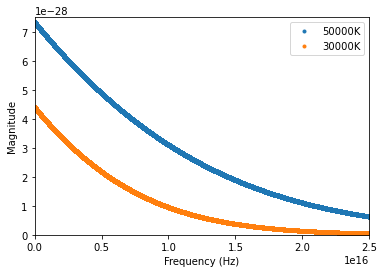

In [4]:
plt.plot(omega,D(omega,50000),'.',label='50000K')
plt.plot(omega,D(omega,T),'.',label='30000K')
plt.xlim(0,25e15)
plt.ylim(0,7.5e-28)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

## $D_n^{\frac{1}{2}}$
$$D_n (\omega,T) = \frac{6\hbar^2}{\pi k_B^2  T^2}\left(\frac{\omega}{\exp\frac{\hbar\omega}{k T}-1}\right)$$

In [5]:
#define square root of Dn function
def Dnsqt(wla,T):
    return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)
wla = np.linspace(0,2*np.pi*2*M/tsim, 2*M)

## 繪圖
#### $\frac{\delta}{\sqrt{\tau_{sim}}} D_n^{\frac{1}{2}}$
#### ($D_n^{\frac{1}{2}}$)

/tmp/ipykernel_184/31513160.py:3: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)
/tmp/ipykernel_184/31513160.py:3: RuntimeWarning: overflow encountered in exp
  return np.sqrt(6*hdk**2*wla/(np.exp(hdk*wla/T)-1)/T**2/np.pi)


Text(0, 0.5, 'Magnitude')

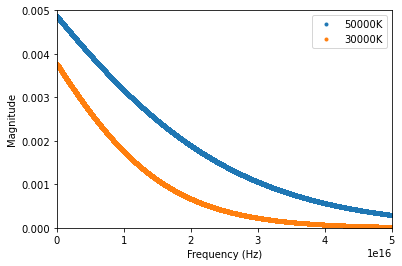

In [6]:
plt.plot(wla,deltap*Dnsqt(abs(wla),50000)*5/3/np.sqrt(tsim),'.',label='50000K')
plt.plot(wla,deltap*Dnsqt(abs(wla),T)/np.sqrt(tsim),'.',label='30000K')
plt.ylim(0,0.005)
#plt.plot(omega,Dnsqt(abs(omega),50000),'.',label='50000K')
#plt.plot(omega,Dnsqt(abs(omega),T),'.',label='30000K')
#plt.ylim(0,3e-8)
plt.xlim(0,50e15)
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

## 設定空Dn數列
因為$ 1 \sim M = -1 \sim -M $conjutated to each other  

In [7]:
#generate an array of the square root of Dn function
Dsqt = []
for n in range(1,M):
    Dsqt.append(Dnsqt(2*np.pi*n/tsim,T))

## 設定重複計算頻均次數

In [8]:
#define how many times to run to average the results
Ncomp=10
#define the starting sum of the result
Efsum = np.zeros(2*M)

## FFT 過程 包含數列擺正
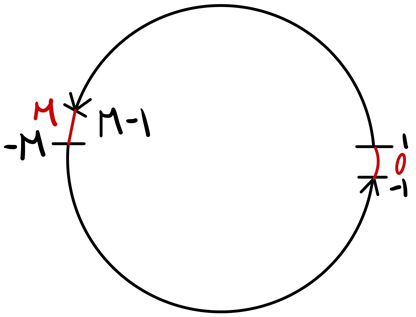  
When $\omega = 0$ causes the numerical problem. The remedy is to use Taylor expansion as $x\ll 1$.

$$\frac{1}{\exp{x}-1} = 1 - \frac{x}{2} + \frac{x^2}{12}-\frac{x^4}{720}+O(x^6)$$  
so $ M = 0 $ calculate separately  
and calculate separately $ M = 1 $ to make FFT complete

因FFT本身是由 $-M \to M$  
但數列轉換為$0 \to 1 \sim M-1 \to M \to -M \sim -1$  
$E_{f0} \Rightarrow M = 0$  
$E_{flp} \Rightarrow M = 1 \sim M-1$  
$E_{flm} \Rightarrow M = -1 \sim -M$  
$E_{fM} \Rightarrow M = M$  
$E_f \Rightarrow E_{f0} \to E_{flp} \to E_{fM} \to E_{flm}$  


##### $E_{fn} = \frac{\delta E_f}{\sqrt{\tau_{sim}}} $

$E_n = iFFT[E_{fn}]$  

$Eautocf = FFT[E_n]$  

$Ef_{avg} = Ef_{avg}/Ncomp$  

In [9]:
for i in range(Ncomp):
    
    #generate random numbers
    M0 = np.random.normal(0,1)
    Mlp = np.random.normal(0,1,M-1)
    Nlp = np.random.normal(0,1,M-1)
    MM = np.random.normal(0,1)
    
    #generate the array of the fourier transform of E field, we generate l=0 and l=-M separately. 
    #for l=1 to M-1 and l=-1 to -(M-1) are conjutated to each other. 
    #we contruct the whole array by gluing them together by the order from l=0 -> l=M-1 -> l=-M -> l=-(m-1) -> l=-1
    Ef0 = np.array([M0*np.sqrt(6*hdk/np.pi/T)])
    Eflp = np.multiply((Mlp + 1j*Nlp), Dsqt)
    Eflm = np.flip(np.conjugate(Eflp))
    EfM = np.array([MM*Dnsqt(2*np.pi*M/tsim,T)])
    Ef = np.hstack((Ef0,Eflp,EfM,Eflm))
    
    #we normalize Ef and compute its inverse fast fourier transform
    Efn = deltap/np.sqrt(tsim)*Ef
    En = np.fft.ifft(Efn)
    
    #we compute self correlation of En
    Eautoc = signal.correlate(En,En)
    Eautocf = np.fft.fft(Eautoc[len(En)-1:])
    
    #extract the real value and add the value of this loop to the total sum
    Eautocf = np.real(Eautocf)
    Efsum += Eautocf
    
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('m'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)

#average the final result
Efavg = Efsum/Ncomp



[mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm] 90%

## 紀錄 數據

In [10]:
#save data to some file or reload file to write more data on it
#np.savez("Efavg_v3.npz", Efavg_30000 = Efavg)
#data = np.load("Efavg_v3.npz")
#data = dict(data)
#data["Efavg_30000"] = Efavg
#np.savez("Efavg_v3.npz",**data)


Text(0, 0.5, 'Magnitude')

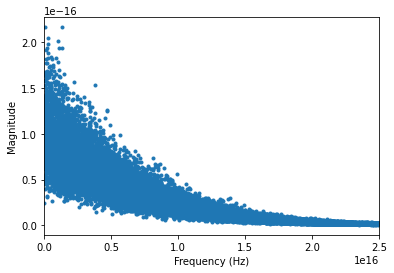

In [11]:
plt.plot(wla,Efavg*tsim,'.')
plt.xlim(0,25*1e15)
#plt.ylim(0,8*1e-28)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

Text(0, 0.5, 'Electric field source Es')

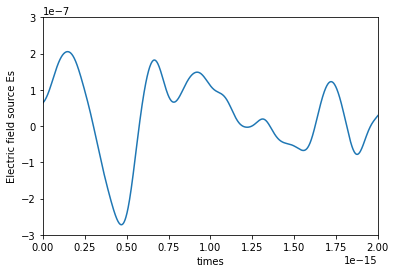

In [15]:
timess = np.linspace(0,7*1e-12,4194304)
plt.plot(timess,En)
plt.xlim(0,2*1e-15)
plt.ylim(-3e-7,3e-7)
plt.xlabel('times')
plt.ylabel('Electric field source Es')

In [ ]:
timesss = np.linspace(-7*1e-12,7*1e-12,M*4-1)
plt.plot(timesss,Eautoc)
plt.xlim(-1e-15,1e-15)
plt.ylim(0,1e-7)
plt.xlabel('times')
plt.ylabel('Correlation function')